In [53]:
from influxdb import InfluxDBClient
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')
from pandas import read_csv

In [54]:
folderNames = ['s1t1rc1nc1t2largedbaccessmovieappt2nanofch', 's1t1rc1nc1t2largedbaccessmovieappt2micro8uf',
              's1t1rc1nc1t2largedbaccessmovieappt2smallhs9',
              
               's1t1rc1nc1t2mediumdbaccessmovieappt2nanomtp','s1t1rc1nc1t2mediumdbaccessmovieappt2microy64',
               's1t1rc1nc1t2mediumdbaccessmovieappt2small3rz',
               
               's1t1rc1nc1t2xlargedbaccessmovieappt2nanor1n', 's1t1rc1nc1t2xlargedbaccessmovieappt2micro8zu',
               's1t1rc1nc1t2xlargedbaccessmovieappt2smallpn8', 's1t1rc1nc1t2xlargedbaccessmovieappt2mediumdvw',
               's1t1rc1nc1t2xlargedbaccessmovieappt2largejn8',
               
               'sv1t1rc1nc1t2nanodbaccessmovieappfalsezoss', 'sv1t1rc1nc1t2microdbaccessmovieappfalseloya',
               'sv1t1rc1nc1t2smalldbaccessmovieappfalsec2tp','sv1t1rc1nc1t2mediumdbaccessmovieappfalsedv3acs',
               'sv1t1rc1nc1t2largedbaccessmovieappfalsee1hics'
              ]


host = '141.40.254.21'
port = 8086
username= 'root'
password = 'root'
appnames  = ["movieapp"]


In [55]:
def getAllNodeNames(client):
    queryResult = client.query("SHOW TAG VALUES FROM uptime WITH KEY=nodename;")
    nodeNames_temp = list(queryResult.get_points())
    dfnodeNames = pd.DataFrame(nodeNames_temp)
    allNodeNames = dfnodeNames[:]["value"]
    return allNodeNames
def getNamespaceNames(client,node):
    nsQuery = client.query("SHOW TAG VALUES FROM uptime WITH KEY=namespace_name WHERE nodename = '"+node+"';")
    nsQuery_temp = list(nsQuery.get_points())
    dfnsNames = pd.DataFrame(nsQuery_temp)
    allnsNames = dfnsNames[:]["value"]
    return allnsNames
def getAllPodNames(client,node,ns_name):
    queryResult = client.query("SHOW TAG VALUES FROM uptime WITH KEY = pod_name WHERE namespace_name = '"+ns_name+"' AND nodename = '"+node+"';")
    podNames_temp = list(queryResult.get_points())
    dfpodNames = pd.DataFrame(podNames_temp)
    if dfpodNames.empty: 
        return dfpodNames
    else:
        allpodNames = dfpodNames[:]["value"]
        return allpodNames
def getCPUUtilizationNode(client, node):
    queryResult = client.query('SELECT * FROM "cpu/node_utilization" where nodename = \''+node+'\' AND type=\'node\';')
    dfcpuUtilization = pd.DataFrame(queryResult['cpu/node_utilization'])
    return dfcpuUtilization
def getCPUUtilizationPod(client, node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "cpu/usage_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfcpuUtilization = pd.DataFrame(queryResult['cpu/usage_rate'])
    return dfcpuUtilization
def getCPUUtilizationPodContainer(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "cpu/usage_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\' AND type=\'pod_container\';')
    dfcpuUtilization = pd.DataFrame(queryResult['cpu/usage_rate'])
    return dfcpuUtilization
def prepareCpuUtilization(client,node,ns_name, pod_name):
    cpuUtilization = getCPUUtilizationNode(client,node)
    podCpuUtilization = getCPUUtilizationPod(client,node,ns_name, pod_name)
    containercpuUtilization = getCPUUtilizationPodContainer(client,node,ns_name, pod_name)
    plt.plot(cpuUtilization.index, cpuUtilization['value'] *1000, 'r', label="node") # plotting t, a separately 
    plt.plot(podCpuUtilization.index, podCpuUtilization['value'], 'b', label="pod") # plotting t, b separately 
    plt.plot(containercpuUtilization.index, containercpuUtilization['value'], 'g', label="container") # plotting t, c separately
    plt.legend(loc='upper left')
    plt.show()
def getMemoryUtilizationNode(client,node):
    queryResult = client.query('SELECT * FROM "memory/node_utilization" where nodename = \''+node+'\' AND type=\'node\';')
    dfmemUtilization = pd.DataFrame(queryResult['memory/node_utilization'])
    return dfmemUtilization
def getMemoryUtilizationPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "memory/usage" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['memory/usage'])
    return dfmemUtilization
def getMemoryUtilizationPodContainer(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "memory/usage" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\' AND type=\'pod_container\';')
    dfmemUtilization = pd.DataFrame(queryResult['memory/usage'])
    return dfmemUtilization
def prepareMemoryUtilization(client,node,ns_name, pod_name):
    memoryUtilization = getMemoryUtilizationNode(client,node)
    podMemoryUtilization = getMemoryUtilizationPod(client,node,ns_name, pod_name)
    containerMemoryUtilization = getMemoryUtilizationPodContainer(client,node,ns_name, pod_name)
    plt.plot(memoryUtilization.index, memoryUtilization['value'], 'r', label="node") # plotting t, a separately 
    plt.plot(podMemoryUtilization.index, podMemoryUtilization['value'], 'b', label="pod") # plotting t, b separately 
    plt.plot(containerMemoryUtilization.index, containerMemoryUtilization['value'], 'g', label="container") # plotting t, c separately 
    plt.legend(loc='upper left')
    plt.show()
def getNetworkTxRatePod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/tx_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/tx_rate'])
    return dfmemUtilization
def getNetworkTxPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/tx" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/tx'])
    return dfmemUtilization
def getNetworkTxErrorsPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/tx_errors" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/tx_errors'])
    return dfmemUtilization
def getNetworkTxErrorsRatePod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/tx_errors_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/tx_errors_rate'])
    return dfmemUtilization
def prepareNetworkTxRateUtilization(client,node,ns_name, pod_name):
    podNetworTxRate = getNetworkTxRatePod(client,node,ns_name, pod_name)
    podNetworTx = getNetworkTxPod(client,node,ns_name, pod_name)
    podNetworkError = getNetworkTxErrorsPod(client,node,ns_name, pod_name)
    podNetworkErrorRate = getNetworkTxErrorsRatePod(client,node,ns_name, pod_name)
    plt.plot(podNetworTxRate.index, podNetworTxRate['value'], 'b') # plotting t, b separately 
    #plt.plot(podNetworTx.index, podNetworTx['value'], 'g') # plotting t, b separately 
    #plt.plot(podNetworkError.index, podNetworkError['value'], 'y') # plotting t, b separately 
    plt.plot(podNetworkErrorRate.index, podNetworkErrorRate['value'], 'r') # plotting t, b separately 
    plt.show()
def getNetworkRxRatePod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/rx_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/rx_rate'])
    return dfmemUtilization
def getNetworkRxPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/rx" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/rx'])
    return dfmemUtilization

def getNetworkRxErrorsPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/rx_errors" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/rx_errors'])
    return dfmemUtilization
def getNetworkRxErrorsRatePod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/rx_errors_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/rx_errors_rate'])
    return dfmemUtilization
def prepareNetworkRxRateUtilization(client,node,ns_name, pod_name):
    podNetworRxRate = getNetworkRxRatePod(client,node,ns_name, pod_name)
    podNetworRx = getNetworkRxPod(client,node,ns_name, pod_name)
    podNetworkError = getNetworkRxErrorsPod(client,node,ns_name, pod_name)
    podNetworkErrorRate = getNetworkRxErrorsRatePod(client,node,ns_name, pod_name)
    plt.plot(podNetworRxRate.index, podNetworRxRate['value'], 'b') # plotting t, b separately 
    #plt.plot(podNetworRx.index, podNetworRx['value'], 'g') # plotting t, b separately 
    #plt.plot(podNetworkError.index, podNetworkError['value'], 'y') # plotting t, b separately 
    plt.plot(podNetworkErrorRate.index, podNetworkErrorRate['value'], 'r') # plotting t, b separately 
    plt.show()
def getRelevantNodeName(client,ns_name):
    allNodeNames  = getAllNodeNames(client)
    #nsNames = getNamespaceNames(allNodeNames[0])
    for node in allNodeNames:
        allPodNamesNode = getAllPodNames(client,node,ns_name)
        if(not allPodNamesNode.empty):
            return node

def getNodeResourceUtilizationDf(client, nodeName):
    Result_node_CPU = client.query("SELECT value from \"cpu/node_utilization\" where nodename = '"+nodeName+"' AND type = 'node' ")
    Result_node_MEM = client.query("SELECT value from \"memory/node_utilization\" where nodename = '"+nodeName+"' AND type = 'node' ")

    Result_node_CPU_Cores = client.query("SELECT mean(\"value\") FROM \"cpu/node_capacity\" where nodename = '"+nodeName+
                                         "' AND type = 'node' GROUP BY time(1m)")
    Result_node_mem_node = client.query("SELECT mean(\"value\")FROM \"memory/node_capacity\" where nodename = '"+
                                        nodeName+"' AND type = 'node' GROUP BY time(1m)")
    
    cpu_points = pd.DataFrame(Result_node_CPU.get_points())
    cpu_points['time'] = pd.to_datetime(cpu_points['time'])
    cpu_points = cpu_points.set_index('time')
    cpu_points.columns = ['node_cpu_util']
    mem_points = pd.DataFrame(Result_node_MEM.get_points())
    mem_points['time'] = pd.to_datetime(mem_points['time'])
    mem_points = mem_points.set_index('time')
    mem_points.columns = ['node_mem_util']
    
    cores_points = pd.DataFrame(Result_node_CPU_Cores.get_points())
    cores_points['time'] = pd.to_datetime(cores_points['time'])
    cores_points = cores_points.set_index('time')
    cores_points.columns = ['node_cores']
    
    mem_node_points = pd.DataFrame(Result_node_mem_node.get_points())
    mem_node_points['time'] = pd.to_datetime(mem_node_points['time'])
    mem_node_points = mem_node_points.set_index('time')
    mem_node_points.columns = ['node_mem']
    
    df_node =pd.concat([cpu_points, mem_points,cores_points,mem_node_points], axis=1)
    return df_node
def getPodResourceUtilizationDf(client, node, ns_name, pod_name):
    Result_Pod_CPU_usage = client.query('SELECT value FROM "cpu/usage_rate" where nodename = \''+node+
                                        '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                        '\'  AND type=\'pod\';')
    Result_Pod_MEM_usage = client.query('SELECT value from \"memory/usage\" where nodename = \''+node+
                                        '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                        '\'  AND type=\'pod\';')
    
    Result_Pod_CPU_limit = client.query('SELECT mean(\"value\") FROM "cpu/limit" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\' group by time(1m);')
    Result_Pod_MEM_limit = client.query('SELECT mean(\"value\") from \"memory/limit\" where nodename = \''+node+
                                        '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                        '\'  AND type=\'pod\' group by time(1m);')
    
    Result_Pod_CPU_requests = client.query('SELECT mean(\"value\") FROM "cpu/request" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\' group by time(1m);')
    Result_Pod_MEM_requests = client.query('SELECT mean(\"value\") from \"memory/request\" where nodename = \''+node+
                                           '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                           '\'  AND type=\'pod\' group by time(1m);')
    
    
    cpu_points_usage = pd.DataFrame(Result_Pod_CPU_usage.get_points())
    cpu_points_usage['time'] = pd.to_datetime(cpu_points_usage['time'])
    cpu_points_usage = cpu_points_usage.set_index('time')
    cpu_points_usage.columns = ['pod_cpu_usage']
    
    
    mem_points_usage = pd.DataFrame(Result_Pod_MEM_usage.get_points())
    mem_points_usage['time'] = pd.to_datetime(mem_points_usage['time'])
    mem_points_usage = mem_points_usage.set_index('time')
    mem_points_usage.columns = ['pod_mem_usage']
    
     
    cpu_points_limits = pd.DataFrame(Result_Pod_CPU_limit.get_points())
    cpu_points_limits['time'] = pd.to_datetime(cpu_points_limits['time'])
    cpu_points_limits = cpu_points_limits.set_index('time')
    cpu_points_limits.columns = ['pod_cpu_limit']
    
    
    mem_points_limits = pd.DataFrame(Result_Pod_MEM_limit.get_points())
    mem_points_limits['time'] = pd.to_datetime(mem_points_limits['time'])
    mem_points_limits = mem_points_limits.set_index('time')
    mem_points_limits.columns = ['pod_mem_limit']
    
     
    cpu_points_request = pd.DataFrame(Result_Pod_CPU_requests.get_points())
    cpu_points_request['time'] = pd.to_datetime(cpu_points_request['time'])
    cpu_points_request = cpu_points_request.set_index('time')
    cpu_points_request.columns = ['pod_cpu_request']
    
    
    mem_points_request = pd.DataFrame(Result_Pod_MEM_requests.get_points())
    mem_points_request['time'] = pd.to_datetime(mem_points_request['time'])
    mem_points_request = mem_points_request.set_index('time')
    mem_points_request.columns = ['pod_mem_request']
       
    df_pod =pd.concat([cpu_points_usage, mem_points_usage,cpu_points_limits,mem_points_limits,cpu_points_request,mem_points_request ], axis=1)
    
    return df_pod
def getRequestsDf(clientK6):
    queryResult = clientK6.query('SELECT sum("value") FROM "vus" group by time(1m);')
    vus = pd.DataFrame(queryResult['vus'])
    vus.columns = ['vus','time']
    vus = vus.set_index('time')


    queryResultReqs = clientK6.query('SELECT sum("value") FROM "http_reqs" group by time(1m);')
    reqs = pd.DataFrame(queryResultReqs['http_reqs'])
    reqs.columns = ['requests','time']
    reqs = reqs.set_index('time')
    queryResultReqsDuration95 = clientK6.query('SELECT percentile("value", 95) FROM "http_req_duration" group by time(1m) ;')
    reqs_duration95 = pd.DataFrame(queryResultReqsDuration95['http_req_duration'])
    reqs_duration95.columns = [ 'requests_duration_percentile_95','time']
    reqs_duration95 = reqs_duration95.set_index('time')
    queryResultReqsDuration90 = clientK6.query('SELECT percentile("value", 90) FROM "http_req_duration" group by time(1m) ;')
    reqs_duration90 = pd.DataFrame(queryResultReqsDuration90['http_req_duration'])
    reqs_duration90.columns = ['requests_duration_percentile_90','time']
    reqs_duration90 = reqs_duration90.set_index('time')

    queryResultMaxDuration = clientK6.query('SELECT max("value") FROM "http_req_duration" group by time(1m);')
    reqs_duration_max = pd.DataFrame(queryResultMaxDuration['http_req_duration'])
    reqs_duration_max.columns = ['requests_duration_max','time']
    reqs_duration_max = reqs_duration_max.set_index('time')

    queryResultMinDuration = clientK6.query('SELECT min("value") FROM "http_req_duration" group by time(1m);')
    reqs_duration_min = pd.DataFrame(queryResultMinDuration['http_req_duration'])
    reqs_duration_min.columns = ['requests_duration_min','time']
    reqs_duration_min = reqs_duration_min.set_index('time')

    queryResultMeanDuration = clientK6.query('SELECT mean("value") FROM "http_req_duration" group by time(1m);')
    reqs_duration_mean = pd.DataFrame(queryResultMeanDuration['http_req_duration'])
    reqs_duration_mean.columns = ['requests_duration_mean','time']
    reqs_duration_mean = reqs_duration_mean.set_index('time')

    queryResultMedianDuration = clientK6.query('SELECT median("value") FROM "http_req_duration" group by time(1m);')
    reqs_duration_median = pd.DataFrame(queryResultMedianDuration['http_req_duration'])
    reqs_duration_median.columns = ['requests_duration_median','time']
    reqs_duration_median = reqs_duration_median.set_index('time')

    finalDF = pd.merge(vus, reqs, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF, reqs_duration95, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF, reqs_duration90, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF,reqs_duration_max, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF,reqs_duration_min, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF,reqs_duration_mean, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF,reqs_duration_median, left_index=True, right_index=True)
    finalDF.index = pd.to_datetime(finalDF.index)

    return finalDF

def getPodsNodesRequestsDf(client, clientK6):
    default_ns_name =  "default"
    relevantNodeName = getRelevantNodeName(client,default_ns_name)
    podNames = getAllPodNames(client,relevantNodeName, default_ns_name)
    df_node = getNodeResourceUtilizationDf(client,relevantNodeName)
    df_pods_node = []
    for podName in podNames: 
        if appnames[0] in podName: 
            df_pod = getPodResourceUtilizationDf(client,relevantNodeName, default_ns_name, podName)
            finalDF = pd.merge(df_node,df_pod, left_index=True, right_index=True)
            requestsDF = getRequestsDf(clientK6)
            finalDF = pd.merge(finalDF,requestsDF, left_index=True, right_index=True)
            finalDF['pod_cpu_usage'] = finalDF['pod_cpu_usage']/(finalDF['pod_cpu_limit'])
            finalDF['pod_cpu_limit'] = finalDF['pod_cpu_limit']/1000
            finalDF['pod_cpu_request'] = finalDF['pod_cpu_request']/1000

            finalDF['pod_mem_usage'] = finalDF['pod_mem_usage']/(finalDF['pod_mem_limit'])
            finalDF['pod_mem_limit'] = finalDF['pod_mem_limit']/(1073741824)
            finalDF['pod_mem_request'] = finalDF['pod_mem_request']/(1073741824)

            finalDF['node_cores'] = finalDF['node_cores']/1000
            finalDF['node_mem'] = finalDF['node_mem']/(1073741824)

            finalDF = finalDF.fillna(0)
            finalDF = finalDF[(finalDF.T != 0).any()]
            df_pods_node.append(finalDF)
    return df_pods_node

In [56]:
clientK6 = InfluxDBClient(host, port, username, password, folderName+'_TestK6')

In [62]:
queryResultMeanDuration = clientK6.query('SELECT sum("value") FROM "vus" group by time(1m);')
queryResultMeanDuration

ResultSet({'('vus', None)': [{'time': '2018-08-19T13:23:00Z', 'sum': 52}, {'time': '2018-08-19T13:24:00Z', 'sum': 268}, {'time': '2018-08-19T13:25:00Z', 'sum': 441}, {'time': '2018-08-19T13:26:00Z', 'sum': 634}, {'time': '2018-08-19T13:27:00Z', 'sum': 1045}, {'time': '2018-08-19T13:28:00Z', 'sum': 1250}, {'time': '2018-08-19T13:29:00Z', 'sum': 1360}, {'time': '2018-08-19T13:30:00Z', 'sum': 1546}, {'time': '2018-08-19T13:31:00Z', 'sum': 1689}, {'time': '2018-08-19T13:32:00Z', 'sum': 2451}, {'time': '2018-08-19T13:33:00Z', 'sum': 2401}, {'time': '2018-08-19T13:34:00Z', 'sum': 2458}, {'time': '2018-08-19T13:35:00Z', 'sum': 2583}, {'time': '2018-08-19T13:36:00Z', 'sum': 2824}, {'time': '2018-08-19T13:37:00Z', 'sum': 3886}, {'time': '2018-08-19T13:38:00Z', 'sum': 3431}, {'time': '2018-08-19T13:39:00Z', 'sum': 3550}, {'time': '2018-08-19T13:40:00Z', 'sum': 3651}, {'time': '2018-08-19T13:41:00Z', 'sum': 3916}, {'time': '2018-08-19T13:42:00Z', 'sum': 5460}, {'time': '2018-08-19T13:43:00Z', 'su

In [26]:
allFinalDFs = []
for folderName in folderNames:
    client = InfluxDBClient(host, port,username , password, folderName+'_k8s')
    clientK6 = InfluxDBClient(host, port, username, password, folderName+'_TestK6')
    df_pods_node = getPodsNodesRequestsDf(client, clientK6)
    print(folderName)
    finalDF = pd.DataFrame()
    for i in range(len(df_pods_node)):
        df_pods_node[i] = df_pods_node[i].reset_index(drop=True)
        finalDF['pod'+str(i+1)+'_cpu_usage'] = df_pods_node[i]['pod_cpu_usage']
        finalDF['pod'+str(i+1)+'_mem_usage'] = df_pods_node[i]['pod_mem_usage']
    finalDF['num_pods'] = int(len(df_pods_node))
    finalDF = pd.concat([finalDF, df_pods_node[0][['node_cores', 'node_mem','node_cpu_util','node_mem_util', 'pod_cpu_limit', 'pod_cpu_request','pod_mem_limit',
                                                   'pod_mem_request','vus','requests','requests_duration_percentile_95',
                                                  'requests_duration_percentile_90','requests_duration_max', 'requests_duration_min',
                                                   'requests_duration_mean', 'requests_duration_median'
                                                  ]]], axis=1)
    
    allFinalDFs.append(finalDF)

s1t1rc1nc1t2largedbaccessmovieappt2nanofch
s1t1rc1nc1t2largedbaccessmovieappt2micro8uf
s1t1rc1nc1t2largedbaccessmovieappt2smallhs9
s1t1rc1nc1t2mediumdbaccessmovieappt2nanomtp
s1t1rc1nc1t2mediumdbaccessmovieappt2microy64
s1t1rc1nc1t2mediumdbaccessmovieappt2small3rz
sv1t1rc1nc1t2nanodbaccessmovieappfalsezoss
sv1t1rc1nc1t2microdbaccessmovieappfalseloya
sv1t1rc1nc1t2smalldbaccessmovieappfalsec2tp


In [ ]:
allFinalDFs[6]

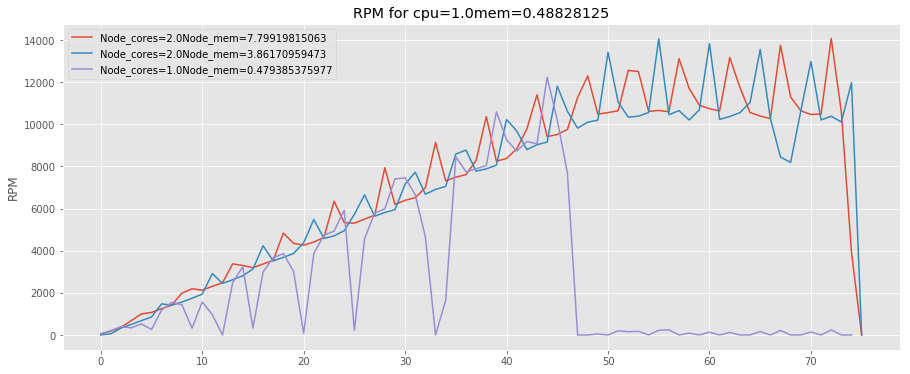

In [51]:
largeNum=0
mediumNum=largeNum+3
vm = largeNum+6

plt.plot(allFinalDFs[largeNum]['requests'], label='Node_cores='+str(allFinalDFs[largeNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[largeNum]['node_mem'][0]))
plt.plot(allFinalDFs[mediumNum]['requests'], label='Node_cores='+str(allFinalDFs[mediumNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[mediumNum]['node_mem'][0]))
plt.plot(allFinalDFs[vm]['requests'], label='Node_cores='+str(allFinalDFs[vm]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[vm]['node_mem'][0]))

plt.title("RPM for "+'cpu='+str(allFinalDFs[largeNum]['pod_cpu_limit'][0])+ 'mem='+str(allFinalDFs[largeNum]['pod_mem_limit'][0]))
plt.ylabel("RPM")
plt.legend()
plt.grid(True)
plt.show()

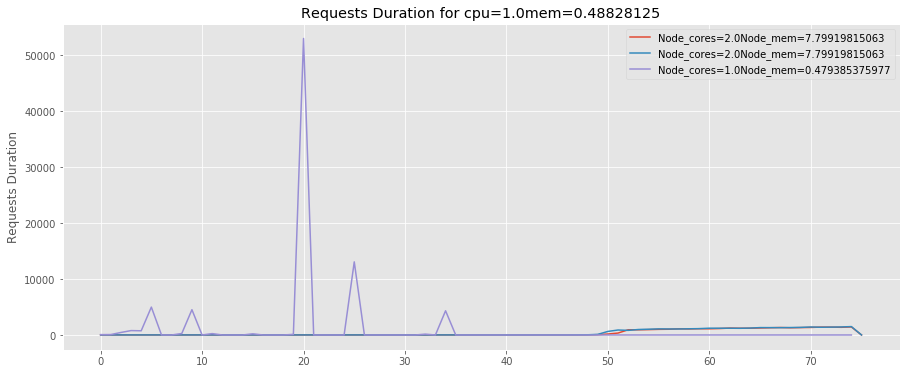

In [48]:
largeNum=0
mediumNum=largeNum+2
vm = largeNum+6

plt.plot(allFinalDFs[largeNum]['requests_duration_mean'], label='Node_cores='+str(allFinalDFs[largeNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[largeNum]['node_mem'][0]))
plt.plot(allFinalDFs[mediumNum]['requests_duration_mean'], label='Node_cores='+str(allFinalDFs[mediumNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[mediumNum]['node_mem'][0]))
plt.plot(allFinalDFs[vm]['requests_duration_mean'], label='Node_cores='+str(allFinalDFs[vm]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[vm]['node_mem'][0]))

plt.title("Requests Duration for "+'cpu='+str(allFinalDFs[largeNum]['pod_cpu_limit'][0])+ 'mem='+str(allFinalDFs[largeNum]['pod_mem_limit'][0]))
plt.ylabel("Requests Duration")
plt.legend()
plt.grid(True)
plt.show()

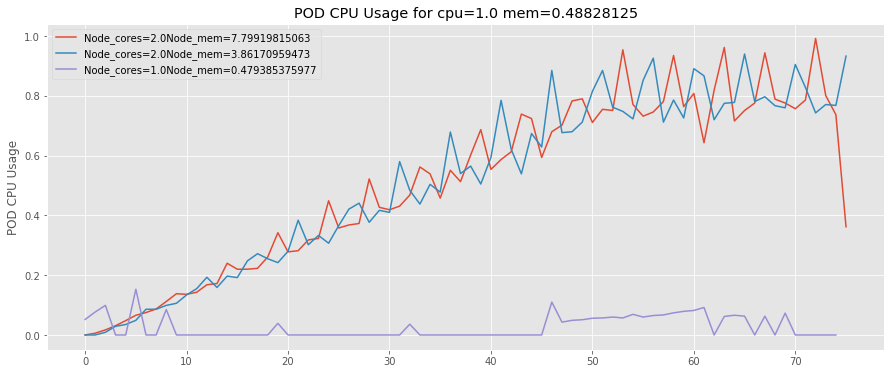

In [38]:
largeNum=0
mediumNum=largeNum+3
vm = largeNum+6

plt.plot(allFinalDFs[largeNum]['pod1_cpu_usage'], label='Node_cores='+str(allFinalDFs[largeNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[largeNum]['node_mem'][0]))
plt.plot(allFinalDFs[mediumNum]['pod1_cpu_usage'], label='Node_cores='+str(allFinalDFs[mediumNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[mediumNum]['node_mem'][0]))
plt.plot(allFinalDFs[vm]['node_cpu_util'], label='Node_cores='+str(allFinalDFs[vm]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[vm]['node_mem'][0]))

plt.title("POD CPU Usage for "+'cpu='+str(allFinalDFs[largeNum]['pod_cpu_limit'][0])+ ' mem='+str(allFinalDFs[largeNum]['pod_mem_limit'][0]))
plt.ylabel("POD CPU Usage")
plt.legend()
plt.grid(True)
plt.show()

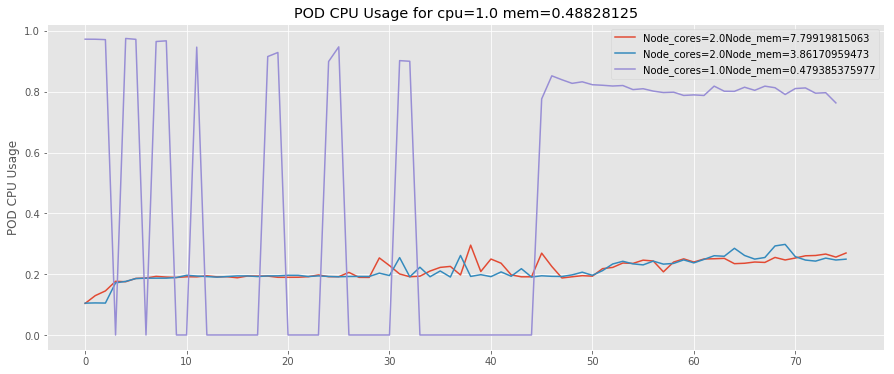

In [50]:
largeNum=0
mediumNum=largeNum+3
vm = largeNum+6

plt.plot(allFinalDFs[largeNum]['pod1_mem_usage'], label='Node_cores='+str(allFinalDFs[largeNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[largeNum]['node_mem'][0]))
plt.plot(allFinalDFs[mediumNum]['pod1_mem_usage'], label='Node_cores='+str(allFinalDFs[mediumNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[mediumNum]['node_mem'][0]))
plt.plot(allFinalDFs[vm]['node_mem_util'], label='Node_cores='+str(allFinalDFs[vm]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[vm]['node_mem'][0]))

plt.title("POD CPU Usage for "+'cpu='+str(allFinalDFs[largeNum]['pod_cpu_limit'][0])+ ' mem='+str(allFinalDFs[largeNum]['pod_mem_limit'][0]))
plt.ylabel("POD CPU Usage")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
largeNum=9
mediumNum=largeNum+3
vm = largeNum+6

plt.plot(allFinalDFs[largeNum]['node_cpu_util'], label='Node_cores='+str(allFinalDFs[largeNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[largeNum]['node_mem'][0]))
plt.plot(allFinalDFs[mediumNum]['node_cpu_util'], label='Node_cores='+str(allFinalDFs[mediumNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[mediumNum]['node_mem'][0]))
plt.plot(allFinalDFs[vm]['node_cpu_util'], label='Node_cores='+str(allFinalDFs[vm]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[vm]['node_mem'][0]))


plt.title("Node CPU Usage for "+'cpu='+str(allFinalDFs[largeNum]['pod_cpu_limit'][0])+ ' mem='+str(allFinalDFs[largeNum]['pod_mem_limit'][0]))
plt.ylabel("Node CPU Usage")
plt.legend()
plt.grid(True)
plt.show()

IndexError: list index out of range

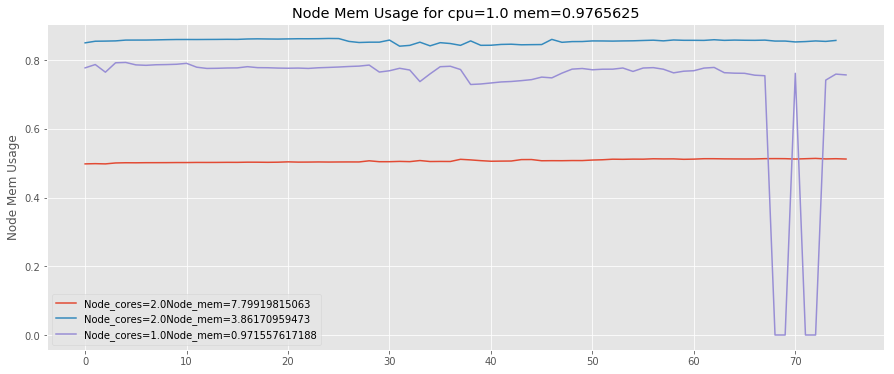

In [21]:
largeNum=1
mediumNum=largeNum+2
vm = largeNum+4

plt.plot(allFinalDFs[largeNum]['node_mem_util'], label='Node_cores='+str(allFinalDFs[largeNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[largeNum]['node_mem'][0]))
plt.plot(allFinalDFs[mediumNum]['node_mem_util'], label='Node_cores='+str(allFinalDFs[mediumNum]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[mediumNum]['node_mem'][0]))
plt.plot(allFinalDFs[vm]['node_mem_util'], label='Node_cores='+str(allFinalDFs[vm]['node_cores'][0])+ 
         'Node_mem='+str(allFinalDFs[vm]['node_mem'][0]))

plt.title("Node Mem Usage for "+'cpu='+str(allFinalDFs[largeNum]['pod_cpu_limit'][0])+ ' mem='+str(allFinalDFs[largeNum]['pod_mem_limit'][0]))
plt.ylabel("Node Mem Usage")
plt.legend()
plt.grid(True)
plt.show()

# Node Utilization (CPU and memory)

In [ ]:
plt.figure()
plt.plot(df_pods_node[0]['node_cpu_util'], label='node_cpu_util')
plt.plot(df_pods_node[0]['node_mem_util'], label='node_mem_util')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(df_pods_node[0]['pod_cpu_usage'], label='pod_cpu_usage')
plt.plot(df_pods_node[0]['pod_mem_usage'], label='pod_mem_usage')
plt.legend()
plt.show()

In [ ]:
df_pods_node[0].fillna(0)
df_pods_node[0].corr()

In [ ]:
dftemp_cpu = df_pods_node[0][['requests','node_cores','node_mem', 'node_cpu_util', 'pod_cpu_usage','pod_cpu_limit','pod_cpu_request','pod_mem_limit','pod_mem_request',  'requests_duration_mean', 'requests_duration_percentile_95']]
dftemp_mem = df_pods_node[0][['requests', 'node_cores','node_mem', 'node_mem_util','pod_cpu_limit','pod_cpu_request','pod_mem_usage','pod_mem_limit','pod_mem_request', 'requests_duration_mean', 'requests_duration_percentile_95']]


In [ ]:
plt.plot( dftemp_cpu['node_cpu_util'], color='blue', linewidth=2)
plt.plot( dftemp_cpu['pod_cpu_usage'], color='red', linewidth=2)

In [ ]:
plt.plot( dftemp_cpu['requests'], color='green', linewidth=2)

In [ ]:
plt.plot(dftemp_cpu['requests_duration_percentile_95'], color='blue', linewidth=2)

In [ ]:
import seaborn as sb

# Linear Regression

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [ ]:
# Use only one feature
df_X = dftemp_cpu[['requests']].values
df_Y = dftemp_cpu[['node_cpu_util']].values

In [ ]:
from numpy import *
from scipy.interpolate import *

In [ ]:
df_X = df_X.flatten()

In [ ]:
df_Y = df_Y.flatten()

In [ ]:
p1=polyfit(df_X, df_Y, 1)

In [ ]:
p2=polyfit(df_X, df_Y, 2)
p3=polyfit(df_X, df_Y, 3)


In [ ]:
plt.plot(df_X, df_Y,'o')
#plt.plot(df_X, polyval(p1,df_X), 'b-')
#plt.plot(df_X, polyval(p2,df_X), 'g-')
plt.plot(df_X, polyval(p3,df_X), 'y-')

In [ ]:
p3

In [ ]:
# Use only one feature
df_X = dftemp_cpu[['pod_cpu_usage', 'pod_cpu_limit']].values
df_Y = dftemp_cpu[['requests']].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# Create linear regression object
model = linear_model.LinearRegression()
#model = Pipeline([('poly', PolynomialFeatures(degree=2)),
#                  ('linear', LinearRegression(fit_intercept=False))])
#regr = linear_model.Ridge (alpha = .01)
#regr = linear_model.Lasso(alpha = 0.1)
#regr = linear_model.LassoLars(alpha=.1)
#regr = make_pipeline(PolynomialFeatures(2), Ridge())

# Train the model using the training sets
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# The coefficients
print('Coefficients: \n', model.coef_)
print('intercept: \n', model.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

#print ('Train score %.2f', regr.score(X_train, y_train) )
#print ('Test score %.2f', regr.score(X_test, y_test) )
#print ('Pred score %.2f', regr.score(X_test, y_pred) )

In [ ]:
# Plot outputs
plt.scatter(X_test[:,0], y_test,  color='black')
#plt.plot(X_test[:,0], y_pred, color='blue')
plt.plot(X_test[:,0],y_pred,'-r')

plt.show()

In [ ]:
model.predict([[0.5, 1]])

In [ ]:
#pd.DataFrame(list(zip(y_pred,y_test)), columns = ['predict', 'test'])

# dataset_pod_hello_world

In [ ]:
dataset_pod_hello_world.index = pd.to_datetime(dataset_pod_hello_world.index)
merged.index = pd.to_datetime(merged.index)

In [ ]:
newmergedhello = dataset_pod_hello_world.reindex(merged.index, method='nearest')
finalDFhello = pd.merge(newmergedhello, merged, left_index=True, right_index=True)
finalDFhello.to_csv('final_hello.csv')


In [ ]:
dfhello = read_csv('final_hello.csv',index_col=0)
dfhello = dfhello.fillna(0)
dfhello = dfhello.sort_values(by=['aggregate.rps.mean'])
dfhello  = dfhello.reset_index()

In [ ]:
dfhello = dfhello[['aggregate.rps.mean', 'cpu', 'aggregate.scenarioDuration.median']]
plt.plot(dfhello['aggregate.rps.mean'], dfhello['cpu'], color='blue', linewidth=3)

In [ ]:
def linear(dft):
    # Use only one feature
    df_X = dft[['aggregate.rps.mean']].values
    df_Y = dft[['cpu']].values
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)
    # Create linear regression object
    regr = linear_model.LinearRegression(normalize=True)
    #regr = linear_model.Ridge (alpha = .5)
    #regr = linear_model.Lasso(alpha = 0.1)
    #regr = linear_model.LassoLars(alpha=.1)
    #regr = make_pipeline(PolynomialFeatures(3), Ridge())

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    print('intercept: \n', regr.intercept_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_test, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))
    print ('Train score %.2f', regr.score(X_train, y_train) )
    print ('Test score %.2f', regr.score(X_test, y_test) )
    print ('Pred score %.2f', regr.score(X_test, y_pred) )
    # Plot outputs
    plt.scatter(X_test, y_test,  color='black')
    plt.plot(X_test, y_pred, color='blue')
    plt.show()


In [ ]:
linear(dfhello)

In [ ]:
dataset_pod_pdescp.index = pd.to_datetime(dataset_pod_pdescp.index)
merged.index = pd.to_datetime(merged.index)
newmergedpdescp = dataset_pod_pdescp.reindex(merged.index, method='nearest')
finalDFpdescp = pd.merge(newmergedpdescp, merged, left_index=True, right_index=True)
finalDFpdescp.to_csv('final_pdescp.csv')
dfpdescp = read_csv('final_pdescp.csv',index_col=0)
dfpdescp = dfpdescp.fillna(0)
dfpdescp = dfpdescp.sort_values(by=['aggregate.rps.mean'])
dfpdescp  = dfpdescp.reset_index()
dfpdescp = dfpdescp[['aggregate.rps.mean', 'cpu']]
plt.plot(dfpdescp['aggregate.rps.mean'], dfpdescp['cpu'], color='blue', linewidth=3)

In [ ]:
linear(dfpdescp)


In [ ]:
dataset_pod_server.index = pd.to_datetime(dataset_pod_server.index)
merged.index = pd.to_datetime(merged.index)
newmergedserver = dataset_pod_server.reindex(merged.index, method='nearest')
finalDFserver = pd.merge(newmergedserver, merged, left_index=True, right_index=True)
finalDFserver.to_csv('final_server.csv')
dfpserver = read_csv('final_server.csv',index_col=0)
dfpserver = dfpserver.fillna(0)
dfpserver = dfpserver.sort_values(by=['aggregate.rps.mean'])
dfpserver  = dfpserver.reset_index()
dfpserver = dfpserver[['aggregate.rps.mean', 'cpu']]
plt.plot(dfpserver['aggregate.rps.mean'], dfpserver['cpu'], color='blue', linewidth=3)

In [ ]:
linear(dfpserver)